# TASK A & B

In [1]:
# Import webdriver from selenium
from selenium import webdriver
chrome_path = r'/Users/abraham.george.j/Desktop/UT/Courses/UGCA/chromedriver'
# prepend it with r because of the backslash characters

In [2]:
driver = webdriver.Chrome(chrome_path)  # This will open up a chrome window

In [3]:
# Take a website that you want to scrape
driver.get("https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p2563")  # It will send you to that website

In [4]:
all_url = []
for i in range(151):
    page = 2563 - i
    all_url.append("https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p" + str(page))

In [5]:
import csv

#driver = webdriver.Chrome(chrome_path)  # This will open up a chrome window

# Take a website that you want to scrape
#driver.get("https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p2563")  # It will send you to that website


with open('results.csv', 'w') as f:
     f.write("Username , Date, UserContent \n")

index = 0
list_len = []
while (index <= 150):
    url = all_url[index]
    driver.get(url)
    username = driver.find_elements_by_class_name("Username")
    date = driver.find_elements_by_tag_name("time")
    usercontent = driver.execute_script('''
                    text=[]
                    var userContents = document.getElementsByClassName("userContent");
                    if (userContents){
                        for(var i=0; i<userContents.length;i++){
                            userContent = userContents[i]
                            childNodes = userContent.childNodes
                            for (var j =0; j<childNodes.length; j++){
                                if(childNodes[j].nodeType == '3'){
                                    if(text[i] == undefined){
                                        if(!childNodes[j].parentNode.className.includes('Signature')){
                                            text[i] = childNodes[j].textContent.trim()
                                        }

                                    }
                                    else{
                                        if(!childNodes[j].parentNode.className.includes('Signature')){
                                            text[i] += childNodes[j].textContent.trim()
                                        }

                                    }
                                }
                            }

                        }

                    }
                    text = text.filter(Boolean)
                    return text''')
    
#     num_page_items = len(username)
#     num_page_contents = len(usercontent)
#     print((num_page_items, num_page_contents, index))
    
    
#     usercontent = driver.find_elements_by_class_name("userContent")
#     userquote = driver.find_elements_by_class_name("UserQuote")
        

#     len_user = len(userquote)
#     len_name = len(username)
#     len_date = len(date)
#     list_len.append(len_user)
#     list_len.append(len_name)
#     list_len.append(len_date)
    
    num_page_items = len(usercontent)
    with open('results.csv', 'a') as f:
        for i in range(num_page_items):
            f.write(username[i].text + "," + date[i].get_attribute("datetime")+","+usercontent[i].replace('\n'," ").replace(','," ")+ "\n")
# #             f.write((userquote[i].text).strip() + "\n")
    index += 1
driver.quit()

In [6]:
# Read the data from the results.csv and the models data
import pandas as pd
results = pd.read_csv("results.csv" )
models = pd.read_csv("models.csv", encoding = "ISO-8859-1", names = ["Brand", "Model"])

In [7]:
comment_data = results.iloc[:,-1]

In [8]:
import re
model_brand_dict = {}
for i in range(len(models)):
    model_brand_dict[(re.sub('[^a-zA-Z\s0-9]+', ' ', str(models.Model[i]))).replace(u'\xa0', u' ').lower()] = models.Brand[i].lower()

In [9]:
cleaned_comment_data = []
for comment in comment_data:
    words = comment.split()
    for word in words:
        if word in model_brand_dict.keys():
            word = model_brand_dict[word]
    cleaned_comment_data.append(' '.join(words))

# Cleaning data

In [10]:
new_comment_string = ""
for x in range(len(cleaned_comment_data)):
    new_comment_string += cleaned_comment_data[x]



In [11]:
# Clean the data
import re

text_clean_step_0_result = re.sub('[^a-zA-Z-]+', ' ', str(new_comment_string))
text_clean_step_1_result = re.sub("\s*-\s*\n", "", str(text_clean_step_0_result))
cleaned_text = text_clean_step_1_result

In [13]:
# lowercase the data
cleaned_text = cleaned_text.lower()


In [14]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
tokens = word_tokenize(cleaned_text)


In [15]:
import enchant
punctuations = ['(',')',';',':','[',']',',', '.', '&', '\n', '=', '∈']
stop_words = stopwords.words('english')
englishDictionary = enchant.Dict("en_US")
keywords = [word for word in tokens if not word in stop_words and not word in punctuations]

In [16]:
# Concatening words which got hyphenated as it reached EOL
# This will help improve the corpus of meaningful words
for i in range(len(keywords)):
    
    if(i < len(keywords)):
        if(keywords[i][-1] == '-'):
            keywords[i] = keywords[i][:-1] + keywords[i]
            del(keywords[i+1])

In [17]:
# Filtering some unwanted data which is present with '-' at the end.

for i in range(len(keywords)):
    if(i < len(keywords)):
        if(keywords[i][-1] == '-'):
            del(keywords[i])

In [18]:
# Since we don't have the model data yet cleaned and ready, lets get the unique values of the brands
# and you can try working with lift values through that
unique_brands = models['Brand'].unique().tolist()
#clean some of the data in brands column
unique_brands.remove('car')
unique_brands.remove('seat')
unique_brands.remove('problem')
unique_brands.remove('sedan')
unique_brands


import re
unique_brand_list = []
for brand in unique_brands:
    unique_brand_list.append((re.sub('[^a-zA-Z]+', ' ', str(brand))).lower().strip())
unique_brand_list = list(set(unique_brand_list))
    #model_brand_dict[(re.sub('[^a-zA-Z\s0-9]+', ' ', str(models.Model[i]))).replace(u'\xa0', u' ').lower()] = models.Brand[i].lower()

In [20]:
# Right now the dictionary list counts all relevant words that havenot been cleaned yet
from operator import itemgetter 
counts = dict()
englishDictionary = enchant.Dict("en_US")

# Aim is to create a dict of dicts
# The key of the outer dict will be each post.
# The value of each key of the outer dict will be a dict.
# The inner dict will contain a list of values of all unique brands which appear in that list

dict_posts = {}
dict_brands = {}
counter = 0 
# Fetching each post from posts
for i in cleaned_comment_data:
    counter += 1
    # Creating a dictionary for each post to store the unique brands mentioned in the post
    brands = {}
    for j in unique_brand_list:
        if len(j) > 1 and j in i.lower():
            if j in counts:
                counts[j] += 1
                continue
            else:
                counts[j] =1
sortedWordsList = sorted(counts.items(), key = itemgetter(1), reverse = True)


In [23]:
top_10_brand_frequency_list = sortedWordsList[:10]
top_10_brand_frequency_list

[('ford', 128),
 ('bmw', 59),
 ('toyota', 50),
 ('nissan', 49),
 ('audi', 48),
 ('kia', 42),
 ('cadillac', 42),
 ('honda', 35),
 ('mercedes', 32),
 ('chrysler', 28)]

In [24]:
# get the brands for the combination prep
top_10_brand_names_only = []
for i in top_10_brand_frequency_list:
    top_10_brand_names_only.append(i[0])
top_10_brand_names_only

['ford',
 'bmw',
 'toyota',
 'nissan',
 'audi',
 'kia',
 'cadillac',
 'honda',
 'mercedes',
 'chrysler']

In [28]:
# create combinations of each pair of brands
import itertools
combination_brand = list(itertools.combinations(top_10_brand_names_only, 2))

In [30]:
# Run the frequency search
combination_frequency = dict()
count = 0
for i in cleaned_comment_data:
    count+=1
    for j in combination_brand:
        if j[0] in i.lower() and j[1] in i.lower():
            if j in combination_frequency:
                combination_frequency[j] += 1
            else:
                combination_frequency[j] = 1


In [34]:
final_combination = {}
for brand_combination in combination_brand:
    if(brand_combination in combination_frequency.keys()):
        final_combination[brand_combination] = combination_frequency[brand_combination]
    else:
        final_combination[brand_combination] = 0


In [35]:
# sort the list
sortedLiftList = sorted(final_combination.items(), key = itemgetter(1), reverse = True)
sortedLiftList

[(('toyota', 'honda'), 15),
 (('bmw', 'mercedes'), 14),
 (('ford', 'kia'), 12),
 (('bmw', 'audi'), 12),
 (('nissan', 'kia'), 12),
 (('ford', 'nissan'), 10),
 (('ford', 'chrysler'), 8),
 (('audi', 'mercedes'), 8),
 (('ford', 'honda'), 7),
 (('ford', 'toyota'), 6),
 (('bmw', 'cadillac'), 6),
 (('cadillac', 'mercedes'), 6),
 (('ford', 'bmw'), 5),
 (('nissan', 'honda'), 5),
 (('audi', 'cadillac'), 5),
 (('bmw', 'honda'), 4),
 (('toyota', 'nissan'), 4),
 (('toyota', 'mercedes'), 4),
 (('kia', 'honda'), 4),
 (('ford', 'cadillac'), 3),
 (('ford', 'mercedes'), 3),
 (('bmw', 'toyota'), 3),
 (('toyota', 'kia'), 3),
 (('toyota', 'chrysler'), 3),
 (('nissan', 'audi'), 3),
 (('kia', 'chrysler'), 3),
 (('honda', 'mercedes'), 3),
 (('ford', 'audi'), 2),
 (('bmw', 'nissan'), 2),
 (('bmw', 'chrysler'), 2),
 (('toyota', 'audi'), 2),
 (('toyota', 'cadillac'), 2),
 (('nissan', 'mercedes'), 2),
 (('nissan', 'chrysler'), 2),
 (('audi', 'kia'), 2),
 (('audi', 'honda'), 2),
 (('cadillac', 'honda'), 2),
 (('ho

In [36]:
# sum is the total number of posts
sum = 4456

In [37]:
l1 = sortedWordsList[:10]
print (l1)

[('ford', 128), ('bmw', 59), ('toyota', 50), ('nissan', 49), ('audi', 48), ('kia', 42), ('cadillac', 42), ('honda', 35), ('mercedes', 32), ('chrysler', 28)]


In [38]:
l2 = l1

In [39]:
l3 = []
for i in l1:
    for j in l2:
        sub_l = [0,0]
        l3.append(sub_l)
        sub_l[0] = (i[0],j[0])
        denom = (i[1]/sum) * (j[1]/sum)
        sub_l[1] = denom

In [40]:
l4 = []
for i in l3:
    for key, value in final_combination.items():
        a, b = i[0][0], i[0][1]
        pair = (b, a)
        if i[0] == key or pair == key:
            sub_list = [0,0]
            l4.append(sub_list)
            numer = value/sum
            lift = numer/i[1]
            sub_list[0]=i[0]
            sub_list[1]=lift
            



In [41]:
k = 0
j = 0
final_lift_list = []


for i in range(len(l4)+10):
    if(i%11 == 0):
        brand = top_10_brand_names_only[k]
        final_lift_list.append([(brand, brand), 1])
        k += 1
    else:
        final_lift_list.append(l4[j])
        j += 1

In [42]:
final_lift_list

[[('ford', 'ford'), 1],
 [('ford', 'bmw'), 2.95021186440678],
 [('ford', 'toyota'), 4.1775],
 [('ford', 'nissan'), 7.104591836734693],
 [('ford', 'audi'), 1.4505208333333333],
 [('ford', 'kia'), 9.946428571428571],
 [('ford', 'cadillac'), 2.486607142857143],
 [('ford', 'honda'), 6.9625],
 [('ford', 'mercedes'), 3.2636718749999996],
 [('ford', 'chrysler'), 9.946428571428571],
 [('bmw', 'ford'), 2.95021186440678],
 [('bmw', 'bmw'), 1],
 [('bmw', 'toyota'), 4.531525423728814],
 [('bmw', 'nissan'), 3.0826703562781046],
 [('bmw', 'audi'), 18.881355932203387],
 [('bmw', 'kia'), 1.798224374495561],
 [('bmw', 'cadillac'), 10.789346246973366],
 [('bmw', 'honda'), 8.631476997578693],
 [('bmw', 'mercedes'), 33.04237288135593],
 [('bmw', 'chrysler'), 5.394673123486683],
 [('toyota', 'ford'), 4.1775],
 [('toyota', 'bmw'), 4.531525423728814],
 [('toyota', 'toyota'), 1],
 [('toyota', 'nissan'), 7.275102040816328],
 [('toyota', 'audi'), 3.713333333333333],
 [('toyota', 'kia'), 6.365714285714286],
 [('

In [43]:
l5 = []
for i in final_lift_list:
    value = i[1]
    l5.append(value)

In [47]:
# to print in matrix form where. the upper triangle is printed.
mat = [[ 0 for x in range(10)] for y in range(10)]
index = 0
for i in range(10):
    for n in range(10):
            mat[i][n] = l5[index]
            index = index +1

for i in range(10):
    for n in range(10):
        if i > n:
            mat[i][n] = None


In [50]:
import pandas as pd
df_lift = pd.DataFrame(mat)

df_lift.columns = ['ford', 'bmw','toyota','nissan','audi','kia','cadillac','honda','mercedes','chrysler']
df_lift.index = ['ford', 'bmw','toyota','nissan','audi','kia','cadillac','honda','mercedes','chrysler']

print (df_lift)

              ford        bmw     toyota     nissan       audi        kia  \
ford      1.000000   2.950212   4.177500   7.104592   1.450521   9.946429   
bmw       2.950212   1.000000   4.531525   3.082670  18.881356   1.798224   
toyota    4.177500   4.531525   1.000000   7.275102   3.713333   6.365714   
nissan    7.104592   3.082670   7.275102   1.000000   5.683673  25.982507   
audi      1.450521  18.881356   3.713333   5.683673   1.000000   4.420635   
kia       9.946429   1.798224   6.365714  25.982507   4.420635   1.000000   
cadillac  2.486607  10.789346   4.243810   2.165209  11.051587   2.526077   
honda     6.962500   8.631477  38.194286  12.991254   5.304762  12.125170   
mercedes  3.263672  33.042373  11.140000   5.683673  23.208333   0.000000   
chrysler  9.946429   5.394673   9.548571   6.495627   3.315476  11.367347   

           cadillac      honda   mercedes   chrysler  
ford       2.486607   6.962500   3.263672   9.946429  
bmw       10.789346   8.631477  33.042373 

In [51]:
l6 = []
for i in l5:
    if i != 0:
        l6.append(1/i)
    else:
        l6.append(i)

In [52]:
mat_l6 = [[ 0 for x in range(10)] for y in range(10)]

index = 0
for i in range(10):
    for n in range(10):
            mat_l6[i][n] = l6[index]
            index = index +1

In [54]:
df_lift_mds = pd.DataFrame(mat_l6)

df_lift_mds.columns = ['ford', 'bmw','toyota','nissan','audi','kia','cadillac','honda','mercedes','chrysler']
df_lift_mds.index = ['ford', 'bmw','toyota','nissan','audi','kia','cadillac','honda','mercedes','chrysler']

print (df_lift_mds)

              ford       bmw    toyota    nissan      audi       kia  \
ford      1.000000  0.338959  0.239378  0.140754  0.689408  0.100539   
bmw       0.338959  1.000000  0.220676  0.324394  0.052962  0.556104   
toyota    0.239378  0.220676  1.000000  0.137455  0.269300  0.157092   
nissan    0.140754  0.324394  0.137455  1.000000  0.175943  0.038487   
audi      0.689408  0.052962  0.269300  0.175943  1.000000  0.226212   
kia       0.100539  0.556104  0.157092  0.038487  0.226212  1.000000   
cadillac  0.402154  0.092684  0.235637  0.461849  0.090485  0.395871   
honda     0.143627  0.115855  0.026182  0.076975  0.188510  0.082473   
mercedes  0.306403  0.030264  0.089767  0.175943  0.043088  0.000000   
chrysler  0.100539  0.185368  0.104728  0.153950  0.301616  0.087971   

          cadillac     honda  mercedes  chrysler  
ford      0.402154  0.143627  0.306403  0.100539  
bmw       0.092684  0.115855  0.030264  0.185368  
toyota    0.235637  0.026182  0.089767  0.104728  
nis

In [55]:
# Start creating the MDS Map
import numpy as np
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state = 15)
embed2d = mds.fit(df_lift_mds.astype(np.float32)).embedding_
x = embed2d[:, 0]
y = embed2d[:, 1]

/anaconda3/lib/python3.6/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'mat', 'sum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


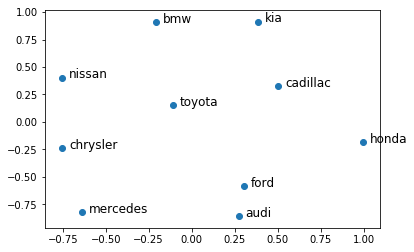

In [56]:
%pylab inline
plt.scatter(x,y)


for i in range(len(l1)):
    plt.annotate(l1[i][0],(x[i]+0.04,y[i]),fontsize=12)
    
plt.show()

# TASK C & D

In [ ]:
# getting the count of all words
from operator import itemgetter 
counts = dict()
englishDictionary = enchant.Dict("en_US")


counter = 0 
# Fetching each post from posts
for i in cleaned_comment_data:
    counter += 1
    
    for j in keywords:
        if len(j) > 1 and j in i.lower():
            if j in counts:
                counts[j] += 1
                continue
            else:
                counts[j] =1
word_list = sorted(counts.items(), key = itemgetter(1), reverse = True)



In [60]:
# get count of attribute
attribute_count = dict()
attributes =  ['performance','wd','trans','price','class']
for word in word_list:
    for value in attributes:
        if word[0] == value:
            attribute_count.update({word[0] : word[1]})
        else:
            continue
            
attribute_count

{'price': 39565, 'class': 3600, 'performance': 928, 'trans': 415, 'wd': 138}

In [61]:
# add the synonyms of the attributes to the current count 

for item in word_list:
    if(item[0]=="engine" or item[0]=='engines' or item[0]=='power' or item[0]=='acceleration' or item[0]=='quality'
        or item[0]=='sport' or item[0]=='miles' or item[0]=='torque' or item[0]=='mileage'
        or item[0]=='speed' or item[0]=='sports'  or item[0]=='weight' or item[0]=='suspension'):
        attribute_count['performance'] += 1
    elif(item[0]=='awd' or item[0]=='rwd' or item[0]=='fwd' or item[0]=='wheel' or item[0]=='wheels'):
        attribute_count['wd'] += 1
    elif(item[0]=='manual'or item[0]=='auto'or item[0]=='automatic'or item[0]=='automatics'or item[0]=='transmission'):
        attribute_count['trans'] += 1
    elif(item[0]=='cheap'or item[0]=='cheaper'or item[0]=='costs'or item[0]=='cost'or item[0]=='economy'or item[0]=='value' or item[0] == 'prices'):
        attribute_count['price'] += 1
    elif(item[0]=='luxury'or item[0]=='interior'or item[0]=='leather'or item[0]=='brand'or item[0]=='premium'
         or item[0]=='seats'or item[0]=='looks'or item[0]=='seat'):
        attribute_count['class'] += 1

In [62]:
attribute_count

{'price': 39572, 'class': 3608, 'performance': 941, 'trans': 419, 'wd': 143}

In [63]:
s = pd.Series(attribute_count, name='freq')
s.index.name = 'attribute'
attr=s.sort_values(ascending=False).reset_index()
attr

,attribute,freq
0,price,39572
1,class,3608
2,performance,941
3,trans,419
4,wd,143


In [64]:
top5_brands = sortedWordsList[:5]
top5_brands

top5_brands_name_only = []

for i in top5_brands:
    top5_brands_name_only.append(i[0])

    
top5_brands_name_only
    

['ford', 'bmw', 'toyota', 'nissan', 'audi']

In [67]:
req_attributes = []
for attr in attribute_count:
    req_attributes.append(attr)

In [80]:
combination_attributes = []
for i in top5_brands_name_only:
    for j in req_attributes:
        if i != j:
            sub_l = [0,0]
            combination_attributes.append(sub_l)
            sub_l[0] = i
            sub_l[1] = j


for x in combination_attributes:
    for y in combination_attributes:
        if x[0] == y[1] and x[1] == y[0]:
            index = combination_attributes.index(y)
            del combination_attributes[index]
            
combination_attributes

[['ford', 'price'],
 ['ford', 'class'],
 ['ford', 'performance'],
 ['ford', 'trans'],
 ['ford', 'wd'],
 ['bmw', 'price'],
 ['bmw', 'class'],
 ['bmw', 'performance'],
 ['bmw', 'trans'],
 ['bmw', 'wd'],
 ['toyota', 'price'],
 ['toyota', 'class'],
 ['toyota', 'performance'],
 ['toyota', 'trans'],
 ['toyota', 'wd'],
 ['nissan', 'price'],
 ['nissan', 'class'],
 ['nissan', 'performance'],
 ['nissan', 'trans'],
 ['nissan', 'wd'],
 ['audi', 'price'],
 ['audi', 'class'],
 ['audi', 'performance'],
 ['audi', 'trans'],
 ['audi', 'wd']]

In [81]:
final_comb_attributes = []
for i in combination_attributes:
    t = tuple(i)
    final_comb_attributes.append(t)
    
final_comb_attributes

[('ford', 'price'),
 ('ford', 'class'),
 ('ford', 'performance'),
 ('ford', 'trans'),
 ('ford', 'wd'),
 ('bmw', 'price'),
 ('bmw', 'class'),
 ('bmw', 'performance'),
 ('bmw', 'trans'),
 ('bmw', 'wd'),
 ('toyota', 'price'),
 ('toyota', 'class'),
 ('toyota', 'performance'),
 ('toyota', 'trans'),
 ('toyota', 'wd'),
 ('nissan', 'price'),
 ('nissan', 'class'),
 ('nissan', 'performance'),
 ('nissan', 'trans'),
 ('nissan', 'wd'),
 ('audi', 'price'),
 ('audi', 'class'),
 ('audi', 'performance'),
 ('audi', 'trans'),
 ('audi', 'wd')]

In [82]:
# Run the frequency search
comb_attributes = dict()
comb_count_attributes = 0
for i in cleaned_comment_data:
    comb_count_attributes+=1
    for j in final_comb_attributes :
        if j[0] in i.lower() and j[1] in i.lower():
            if j in comb_attributes:
                comb_attributes[j] += 1
            else:
                comb_attributes[j] = 1
comb_attributes

{('nissan', 'price'): 12,
 ('audi', 'price'): 5,
 ('bmw', 'price'): 10,
 ('bmw', 'class'): 6,
 ('ford', 'class'): 6,
 ('toyota', 'class'): 2,
 ('nissan', 'class'): 4,
 ('audi', 'class'): 3,
 ('bmw', 'trans'): 2,
 ('ford', 'price'): 19,
 ('toyota', 'price'): 4,
 ('toyota', 'performance'): 3,
 ('toyota', 'trans'): 5,
 ('nissan', 'performance'): 1,
 ('nissan', 'trans'): 4,
 ('ford', 'performance'): 3,
 ('ford', 'trans'): 4,
 ('audi', 'trans'): 1,
 ('ford', 'wd'): 4,
 ('nissan', 'wd'): 1,
 ('bmw', 'wd'): 2,
 ('audi', 'wd'): 2,
 ('bmw', 'performance'): 2}

In [83]:
final_combination_attributes = {}
for i in final_comb_attributes:
    if(i in comb_attributes.keys()):
        final_combination_attributes[i] = comb_attributes[i]
    else:
        final_combination_attributes[i] = 0
        
final_combination_attributes


{('ford', 'price'): 19,
 ('ford', 'class'): 6,
 ('ford', 'performance'): 3,
 ('ford', 'trans'): 4,
 ('ford', 'wd'): 4,
 ('bmw', 'price'): 10,
 ('bmw', 'class'): 6,
 ('bmw', 'performance'): 2,
 ('bmw', 'trans'): 2,
 ('bmw', 'wd'): 2,
 ('toyota', 'price'): 4,
 ('toyota', 'class'): 2,
 ('toyota', 'performance'): 3,
 ('toyota', 'trans'): 5,
 ('toyota', 'wd'): 0,
 ('nissan', 'price'): 12,
 ('nissan', 'class'): 4,
 ('nissan', 'performance'): 1,
 ('nissan', 'trans'): 4,
 ('nissan', 'wd'): 1,
 ('audi', 'price'): 5,
 ('audi', 'class'): 3,
 ('audi', 'performance'): 0,
 ('audi', 'trans'): 1,
 ('audi', 'wd'): 2}

In [84]:
l1_attribute = top5_brands

In [85]:
l2_attribute = attribute_count
sum = 4456

In [86]:
l3_attribute = []
for i in l1_attribute:
    for key, value in l2_attribute.items():
        sub_l = [0,0]
        l3_attribute.append(sub_l)
        sub_l[0] = (i[0],key)
        denom = (i[1]/sum) * (value/sum)
        sub_l[1] = denom

In [87]:
l4_attribute = []
for i in l3_attribute:
    for key, value in final_combination_attributes.items():
        a, b = i[0][0], i[0][1]
        pair = (b, a)
        if i[0] == key or pair == key:
            sub_list = [0,0]
            l4_attribute.append(sub_list)
            numer = value/sum
            lift = numer/i[1]
            sub_list[0]=i[0]
            sub_list[1]=lift

In [89]:
l5_attribute = []
for i in l4_attribute:
    value = i[1]
    l5_attribute.append(value)


In [92]:
mat_attr = [[ 0 for x in range(5)] for y in range(5)]

index = 0
for i in range(5):
    for n in range(5):
            mat_attr[i][n] = l5_attribute[index]
            index = index +1

In [93]:
import pandas as pd
df_lift_attr = pd.DataFrame(mat_attr)

df_lift_attr.columns = ['price', 'class', 'performance', 'trans', 'wd']
df_lift_attr.index = ['ford', 'bmw','toyota','nissan','audi']

print (df_lift_attr)

           price     class  performance     trans        wd
ford    0.016715  0.057892     0.110986  0.332339  0.973776
bmw     0.019086  0.125597     0.160522  0.360503  1.056300
toyota  0.009008  0.049401     0.284123  1.063484  0.000000
nissan  0.027577  0.100819     0.096641  0.868151  0.635935
audi    0.011730  0.077190     0.000000  0.221559  1.298368


# TASK E

In [94]:
aspiration_count = dict()
aspirations =  ['reliability','safety','cost','mileage','reputation']
for word in word_list:
    for value in aspirations:
        if word[0] == value:
            aspiration_count.update({word[0] : word[1]})
        else:
            continue
            
aspiration_count

{'cost': 18012,
 'mileage': 1178,
 'safety': 729,
 'reliability': 256,
 'reputation': 132}

In [98]:
for item in word_list:
    if(item[0]=="accuracy" or item[0]=='accurate' or item[0]=='authenticity' or item[0]=='authentic' or item[0]=='quality'
        or item[0]=='honesty' or item[0]=='honest' or item[0]=='loyalty' or item[0]=='loyal'
        or item[0]=='trust' or item[0]=='trustworthy'  or item[0]=='reliable'):
        aspiration_count['reliability'] += 1
    elif(item[0]=='safe' or item[0]=='secure' or item[0]=='assurance' or item[0]=='cover' or item[0]=='safeness'):
        aspiration_count['safety'] += 1
    elif(item[0]=='amount'or item[0]=='expenditure'or item[0]=='rate'or item[0]=='value'or item[0]=='charge'):
        aspiration_count['cost'] += 1
    elif(item[0]=='miles'or item[0]=='miles/gallon'or item[0]=='distance'or item[0]=='economy'or item[0]=='value' or item[0] == 'prices'):
        aspiration_count['mileage'] += 1
    elif(item[0]=='status'or item[0]=='stature'or item[0]=='esteem'or item[0]=='prestige'or item[0]=='renown'
         or item[0]=='repute'):
        aspiration_count['reputation'] += 1

In [99]:
top5_brands = sortedWordsList[:5]
top5_brands

top5_brands_name_only = []

for i in top5_brands:
    top5_brands_name_only.append(i[0])

    
top5_brands_name_only

['ford', 'bmw', 'toyota', 'nissan', 'audi']

In [100]:
aspiration_list = []
for items in attribute_count:
    aspiration_list.append(items)
    
aspiration_list

['price', 'class', 'performance', 'trans', 'wd']

In [102]:
comb_aspiration = []
for i in top5_brands_name_only:
    for j in aspiration_list:
        if i != j:
            sub_l = [0,0]
            comb_aspiration.append(sub_l)
            sub_l[0] = i
            sub_l[1] = j


for x in comb_aspiration:
    for y in comb_aspiration:
        if x[0] == y[1] and x[1] == y[0]:
            index = comb_aspiration.index(y)
            del comb_aspiration[index]
            

            

In [104]:
final_comb_aspiration = []
for i in comb_aspiration:
    t = tuple(i)
    final_comb_aspiration.append(t)
    


In [105]:
# Run the frequency search
aspiration_d = dict()
aspiration_c = 0
for i in cleaned_comment_data:
    aspiration_c+=1
    for j in final_comb_aspiration :
        if j[0] in i.lower() and j[1] in i.lower():
            if j in aspiration_d:
                aspiration_d[j] += 1
            else:
                aspiration_d[j] = 1

In [106]:
sorted_aspiration_d = sorted(aspiration_d.items(), key = itemgetter(1), reverse = True)
sorted_aspiration_d



[(('ford', 'price'), 19),
 (('nissan', 'price'), 12),
 (('bmw', 'price'), 10),
 (('bmw', 'class'), 6),
 (('ford', 'class'), 6),
 (('audi', 'price'), 5),
 (('toyota', 'trans'), 5),
 (('nissan', 'class'), 4),
 (('toyota', 'price'), 4),
 (('nissan', 'trans'), 4),
 (('ford', 'trans'), 4),
 (('ford', 'wd'), 4),
 (('audi', 'class'), 3),
 (('toyota', 'performance'), 3),
 (('ford', 'performance'), 3),
 (('toyota', 'class'), 2),
 (('bmw', 'trans'), 2),
 (('bmw', 'wd'), 2),
 (('audi', 'wd'), 2),
 (('bmw', 'performance'), 2),
 (('nissan', 'performance'), 1),
 (('audi', 'trans'), 1),
 (('nissan', 'wd'), 1)]